Portfolio Optimization Efficiency Test
Data overview: 2609 days, 25 assets
Data split:
Training: 2015-01-01 to 2021-12-30 (1826 days)
Testing: 2021-12-31 to 2024-12-31 (783 days)

=== Single-shot (no rebalance) comparison ===
Starting backtest...
Building Model A: Multi-Factor Regression Risk Model
Built 5 factors, avg R² = 0.780
Building Model B: Ledoit-Wolf Shrinkage Covariance
Shrinkage intensity = 0.002
Covariance matrix differences:
Frobenius norm difference: 0.001766
Max absolute difference: 0.000280
Average variance difference: 0.21%
Optimizing Model A (Multi-Factor)...
Model A (Multi-Factor): Vol=0.3675, Sharpe=0.0763
Optimizing Model B (Ledoit-Wolf)...
Model B (Ledoit-Wolf): Vol=0.3989, Sharpe=-0.0614
Weight differences:
Max weight difference: 0.0640
Mean weight difference: 0.0198
Top 5 assets with largest weight differences:
Asset_01: A=0.000, B=0.064
Asset_08: A=0.007, B=0.064
Asset_22: A=0.020, B=0.064
Asset_06: A=0.029, B=0.064
Asset_00: A=0.096, B=0.064
Model comparison r

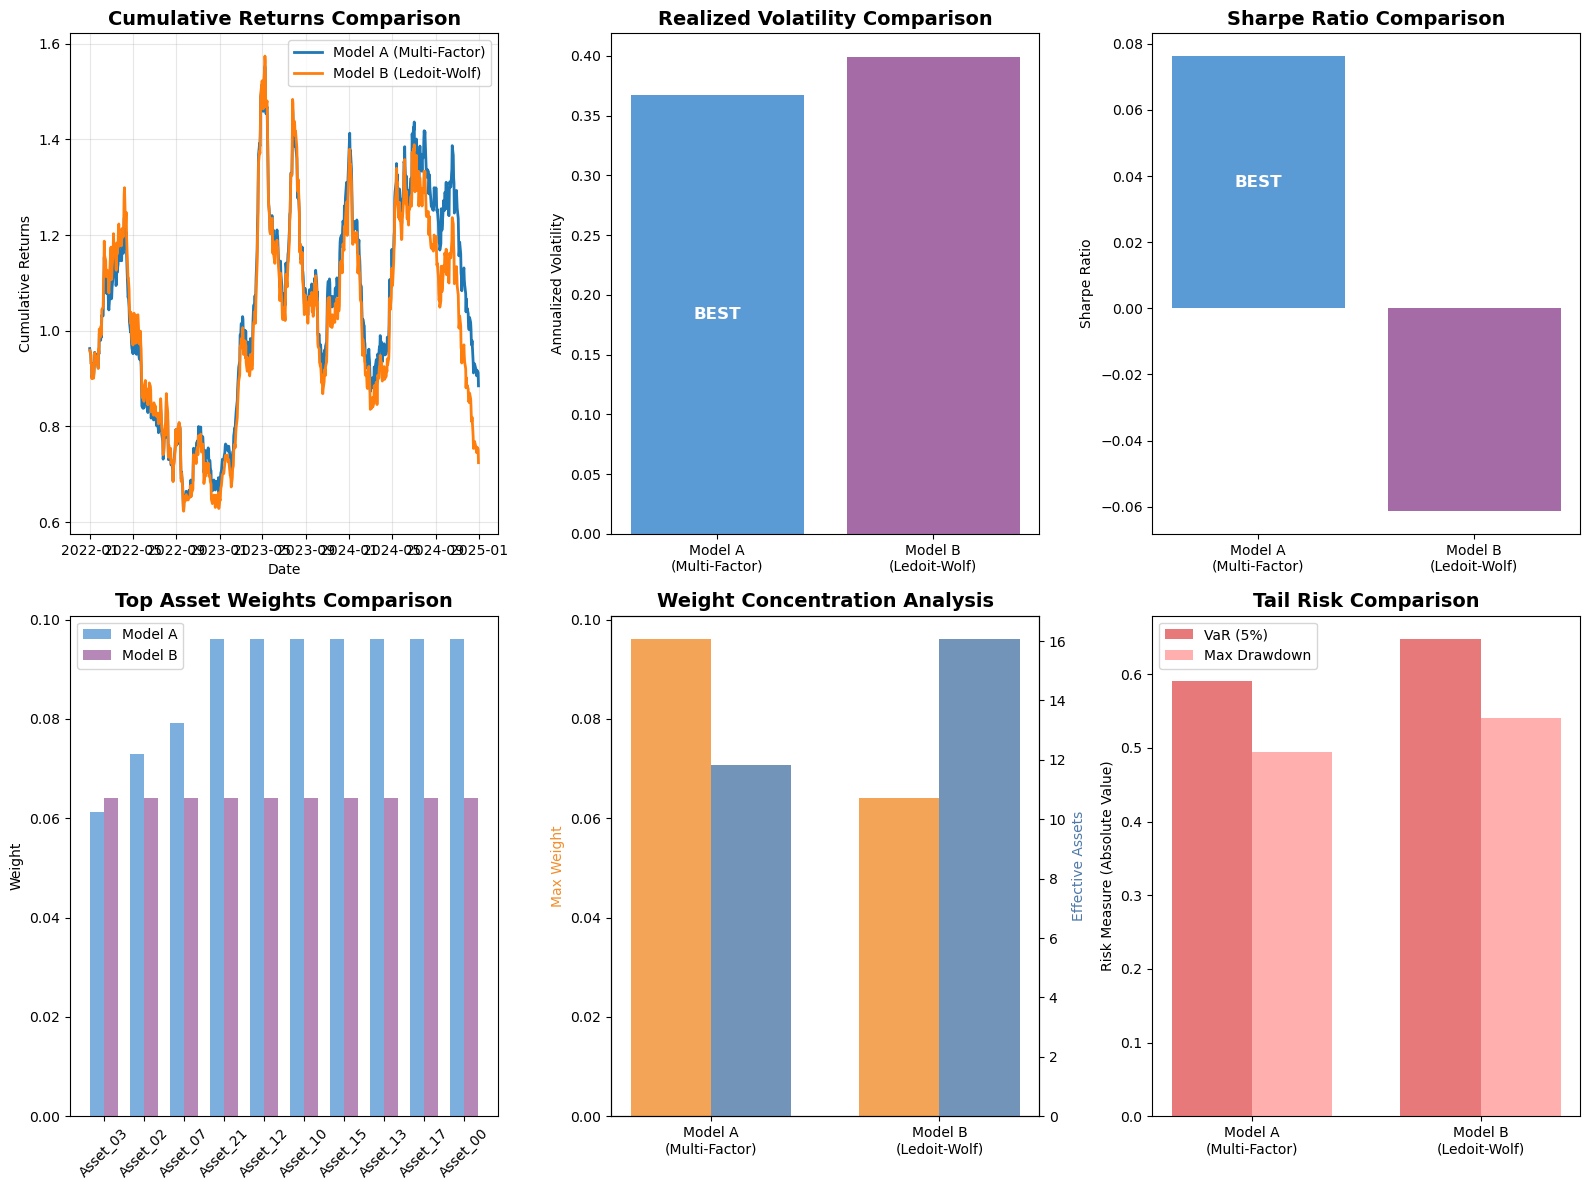


=== Rolling rebalance, multi-horizon comparison (1, 21, 63 bd) ===

Per-rebalance results (wide, head):
 rebalance horizon_bd  Model A  Model B  vol_gap_B_minus_A
2021-12-31          1 0.255787 0.254686          -0.001101
2021-12-31         21 0.280226 0.280459           0.000233
2021-12-31         63 0.326784 0.326967           0.000183
2022-01-31          1 0.403499 0.402906          -0.000593
2022-01-31         21 0.372293 0.371105          -0.001188
2022-01-31         63 0.363266 0.363242          -0.000023
2022-02-28          1 0.060873 0.068134           0.007261
2022-02-28         21 0.330278 0.329885          -0.000393
2022-02-28         63 0.355016 0.354315          -0.000701
2022-03-31          1 0.355471 0.358990           0.003520
2022-03-31         21 0.371093 0.369596          -0.001498
2022-03-31         63 0.350953 0.350554          -0.000400

Summary by horizon:
 horizon_bd  n_rebalances  median_vol_ModelA  median_vol_ModelB  median_vol_gap_B_minus_A  win_rate_ModelA_

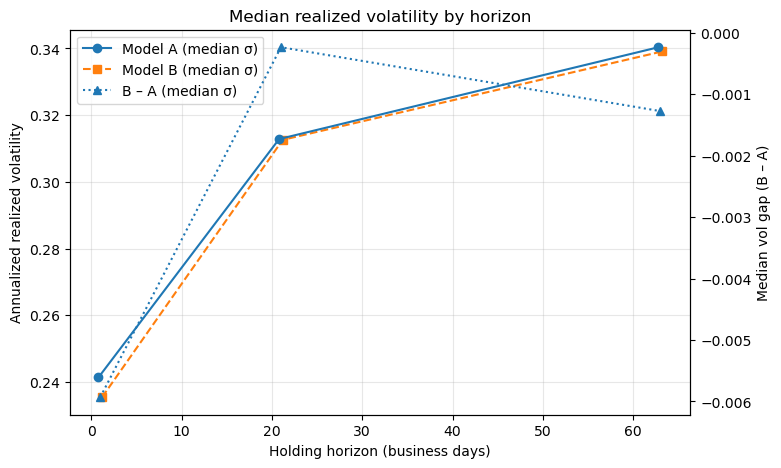

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import BDay 
import warnings

warnings.filterwarnings('ignore')


class ImprovedTwoModelOptimizer:
    def __init__(self, returns_data):
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]
        self.asset_names = returns_data.columns.tolist()

    def split_data(self, split_ratio=0.7):
        """Split training and testing data"""
        split_point = int(len(self.returns) * split_ratio)
        self.train_returns = self.returns.iloc[:split_point]
        self.test_returns = self.returns.iloc[split_point:]

        print(f"Data split:")
        print(
            f"Training: {self.train_returns.index[0].strftime('%Y-%m-%d')} to {self.train_returns.index[-1].strftime('%Y-%m-%d')} ({len(self.train_returns)} days)")
        print(
            f"Testing: {self.test_returns.index[0].strftime('%Y-%m-%d')} to {self.test_returns.index[-1].strftime('%Y-%m-%d')} ({len(self.test_returns)} days)")

    def build_model_a_multi_factor(self):
        """Model A: Multi-Factor Regression Risk Model"""
        print(f"Building Model A: Multi-Factor Regression Risk Model")

        factors = self.construct_enhanced_factors()

        factor_loadings = []
        idiosyncratic_vars = []
        r_squareds = []

        for i, asset in enumerate(self.asset_names):
            asset_returns = self.train_returns[asset].values

            reg = LinearRegression()
            reg.fit(factors, asset_returns)

            factor_loadings.append(reg.coef_)

            predicted = reg.predict(factors)
            residuals = asset_returns - predicted
            idiosyncratic_var = np.var(residuals)
            idiosyncratic_vars.append(idiosyncratic_var)

            r_squared = reg.score(factors, asset_returns)
            r_squareds.append(r_squared)

        B = np.array(factor_loadings)
        factor_cov = np.cov(factors.T)

        factor_component = B @ factor_cov @ B.T

        specific_vars = np.array(idiosyncratic_vars)
        specific_vars = specific_vars * (1 + 0.1 * np.random.RandomState(42).normal(0, 0.1, len(specific_vars)))
        specific_vars = np.maximum(specific_vars, 1e-6)
        specific_component = np.diag(specific_vars)

        self.cov_model_a = factor_component + specific_component

        eigenvals, eigenvecs = np.linalg.eigh(self.cov_model_a)
        eigenvals = np.maximum(eigenvals, 1e-8)
        self.cov_model_a = eigenvecs @ np.diag(eigenvals) @ eigenvecs.T

        avg_r_squared = np.mean(r_squareds)

        print(f"Built {factors.shape[1]} factors, avg R² = {avg_r_squared:.3f}")

        return self.cov_model_a

    def construct_enhanced_factors(self):
        """Construct enhanced economic factors"""
        returns_data = self.train_returns.values

        market_weights = np.random.RandomState(42).uniform(0.5, 1.5, self.n_assets)
        market_weights = market_weights / market_weights.sum()
        market_factor = returns_data @ market_weights

        asset_vols = self.train_returns.std()
        high_vol_idx = asset_vols.nlargest(self.n_assets // 3).index
        low_vol_idx = asset_vols.nsmallest(self.n_assets // 3).index

        size_factor = (self.train_returns[high_vol_idx].mean(axis=1) -
                       self.train_returns[low_vol_idx].mean(axis=1)).values

        momentum_lookback = min(20, len(self.train_returns) // 10)
        momentum_signals = self.train_returns.rolling(momentum_lookback).mean().fillna(0)
        momentum_factor = momentum_signals.mean(axis=1).values

        reversal_factor = -momentum_factor

        vol_lookback = min(10, len(self.train_returns) // 20)
        vol_factor = self.train_returns.rolling(vol_lookback).std().mean(axis=1).fillna(
            self.train_returns.std().mean()).values

        factors = np.column_stack([
            market_factor,
            size_factor,
            momentum_factor,
            reversal_factor,
            vol_factor
        ])

        factors = (factors - factors.mean(axis=0)) / factors.std(axis=0)

        return factors

    def build_model_b_ledoit_wolf(self):
        """Model B: Ledoit-Wolf Shrinkage Covariance"""
        print(f"Building Model B: Ledoit-Wolf Shrinkage Covariance")

        lw = LedoitWolf()
        self.cov_model_b = lw.fit(self.train_returns).covariance_

        shrinkage = lw.shrinkage_

        print(f"Shrinkage intensity = {shrinkage:.3f}")

        return self.cov_model_b

    def diagnose_covariance_differences(self):
        """Diagnose differences between two covariance matrices"""
        print(f"Covariance matrix differences:")

        diff_matrix = self.cov_model_a - self.cov_model_b

        frobenius_diff = np.linalg.norm(diff_matrix, 'fro')
        max_diff = np.max(np.abs(diff_matrix))
        mean_abs_diff = np.mean(np.abs(diff_matrix))

        print(f"Frobenius norm difference: {frobenius_diff:.6f}")
        print(f"Max absolute difference: {max_diff:.6f}")

        var_a = np.diag(self.cov_model_a)
        var_b = np.diag(self.cov_model_b)
        var_diff_pct = np.abs(var_a - var_b) / var_b * 100

        print(f"Average variance difference: {np.mean(var_diff_pct):.2f}%")

        return frobenius_diff, max_diff, mean_abs_diff

    def optimize_portfolio(self, cov_matrix, model_name, max_weight=0.08):
        """Portfolio optimization with different constraints"""
        n_assets = self.n_assets

        def objective(weights):
            return np.dot(weights.T, np.dot(cov_matrix, weights))

        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]

        if 'Multi-Factor' in model_name:
            bounds = tuple([(0, max_weight * 1.2) for _ in range(n_assets)])
        else:
            bounds = tuple([(0, max_weight * 0.8) for _ in range(n_assets)])

        if 'Multi-Factor' in model_name:
            inv_vars = 1 / np.diag(cov_matrix)
            initial_guess = inv_vars / inv_vars.sum()
        else:
            initial_guess = np.array([1.0 / n_assets] * n_assets)

        result = minimize(objective, initial_guess, method='SLSQP',
                          bounds=bounds, constraints=constraints,
                          options={'disp': False, 'ftol': 1e-12})

        if result.success:
            return result.x
        else:
            print(f"{model_name} optimization failed: {result.message}")
            return initial_guess

    def analyze_weight_differences(self):
        """Analyze weight differences"""
        weights_a = self.weights['Model A (Multi-Factor)']
        weights_b = self.weights['Model B (Ledoit-Wolf)']

        weight_diff = np.abs(weights_a - weights_b)
        max_weight_diff = np.max(weight_diff)
        mean_weight_diff = np.mean(weight_diff)

        print(f"Weight differences:")
        print(f"Max weight difference: {max_weight_diff:.4f}")
        print(f"Mean weight difference: {mean_weight_diff:.4f}")

        top_diff_idx = np.argsort(weight_diff)[-5:]
        print(f"Top 5 assets with largest weight differences:")
        for idx in reversed(top_diff_idx):
            asset_name = self.asset_names[idx][:15]
            print(f"{asset_name}: A={weights_a[idx]:.3f}, B={weights_b[idx]:.3f}")

        return max_weight_diff, mean_weight_diff

    def backtest_models(self):
        """Backtest both models"""
        print(f"Starting backtest...")

        cov_a = self.build_model_a_multi_factor()
        cov_b = self.build_model_b_ledoit_wolf()

        self.diagnose_covariance_differences()

        models = {
            'Model A (Multi-Factor)': cov_a,
            'Model B (Ledoit-Wolf)': cov_b
        }

        self.weights = {}
        self.portfolio_returns = {}
        self.results = {}

        for model_name, cov_matrix in models.items():
            print(f"Optimizing {model_name}...")

            weights = self.optimize_portfolio(cov_matrix, model_name)
            self.weights[model_name] = weights

            portfolio_returns = (self.test_returns * weights).sum(axis=1)
            self.portfolio_returns[model_name] = portfolio_returns

            self.results[model_name] = self.calculate_performance_metrics(
                portfolio_returns, weights, model_name
            )

        max_diff, mean_diff = self.analyze_weight_differences()

        if mean_diff < 0.01:
            print(f"Warning: Weight differences are small (mean diff={mean_diff:.4f})")

        return self.results

    def calculate_performance_metrics(self, returns, weights, model_name):
        """Calculate performance metrics"""
        annualize_factor = 252

        metrics = {
            'Realized Volatility': returns.std() * np.sqrt(annualize_factor),
            'Mean Return': returns.mean() * annualize_factor,
            'Sharpe Ratio': (returns.mean() * annualize_factor) / (
                    returns.std() * np.sqrt(annualize_factor)) if returns.std() > 0 else 0,
            'Max Drawdown': self.calculate_max_drawdown(returns),
            'VaR (5%)': np.percentile(returns, 5) * np.sqrt(annualize_factor),
            'Max Weight': np.max(weights),
            'Effective Assets': 1 / np.sum(weights ** 2),
            'Skewness': returns.skew(),
            'Kurtosis': returns.kurtosis()
        }

        print(f"{model_name}: Vol={metrics['Realized Volatility']:.4f}, Sharpe={metrics['Sharpe Ratio']:.4f}")

        return metrics

    def calculate_max_drawdown(self, returns):
        """Calculate maximum drawdown"""
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.expanding().max()
        drawdowns = (cum_returns - rolling_max) / rolling_max
        return drawdowns.min()

    def generate_final_report(self):
        """Generate final report"""
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.round(6)

        print(f"Model comparison results:")
        print("=" * 60)
        print(results_df.to_string())

        model_a_vol = self.results['Model A (Multi-Factor)']['Realized Volatility']
        model_b_vol = self.results['Model B (Ledoit-Wolf)']['Realized Volatility']

        vol_diff = model_b_vol - model_a_vol
        vol_improvement_pct = abs(vol_diff) / max(model_a_vol, model_b_vol) * 100

        if abs(vol_diff) < 1e-6:
            print(f"Results are very similar - volatility difference: {vol_diff:.8f}")
        else:
            better_model = "Model A (Multi-Factor)" if model_a_vol < model_b_vol else "Model B (Ledoit-Wolf)"
            print(f"Better model: {better_model}")
            print(f"Volatility difference: {abs(vol_diff):.6f} ({vol_improvement_pct:.3f}%)")

        return results_df, vol_diff, vol_improvement_pct

    def create_visualization(self):
        """Create comprehensive visualization dashboard"""
        fig = plt.figure(figsize=(16, 12))

        # 1. Cumulative Returns
        ax1 = plt.subplot(2, 3, 1)
        for model_name, returns in self.portfolio_returns.items():
            cum_returns = (1 + returns).cumprod()
            plt.plot(cum_returns.index, cum_returns.values,
                     label=model_name, linewidth=2)
        plt.title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Realized Volatility Comparison
        ax2 = plt.subplot(2, 3, 2)
        vols = [self.results[model]['Realized Volatility'] for model in self.results.keys()]
        colors = ['#5B9BD5', '#A46BA6']
        bars = plt.bar(range(len(vols)), vols, color=colors)
        plt.title('Realized Volatility Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Annualized Volatility')
        plt.xticks(range(len(vols)), ['Model A\n(Multi-Factor)', 'Model B\n(Ledoit-Wolf)'])

        # Add "BEST" labels
        min_vol_idx = np.argmin(vols)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if i == min_vol_idx:
                plt.text(bar.get_x() + bar.get_width() / 2., height / 2,
                         'BEST', ha='center', va='center',
                         fontweight='bold', fontsize=12, color='white')

        # 3. Sharpe Ratio Comparison
        ax3 = plt.subplot(2, 3, 3)
        sharpes = [self.results[model]['Sharpe Ratio'] for model in self.results.keys()]
        bars = plt.bar(range(len(sharpes)), sharpes, color=colors)
        plt.title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Sharpe Ratio')
        plt.xticks(range(len(sharpes)), ['Model A\n(Multi-Factor)', 'Model B\n(Ledoit-Wolf)'])

        # Add efficiency labels
        max_sharpe_idx = np.argmax(sharpes)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if i == max_sharpe_idx:
                plt.text(bar.get_x() + bar.get_width() / 2., height / 2,
                         'BEST', ha='center', va='center',
                         fontweight='bold', fontsize=12, color='white')

        # 4. Top Asset Weights Comparison
        ax4 = plt.subplot(2, 3, 4)
        weights_a = self.weights['Model A (Multi-Factor)']
        weights_b = self.weights['Model B (Ledoit-Wolf)']

        # Get top 10 assets by average weight
        avg_weights = (weights_a + weights_b) / 2
        top_assets_idx = np.argsort(avg_weights)[-10:]

        x = np.arange(len(top_assets_idx))
        width = 0.35

        plt.bar(x - width / 2, weights_a[top_assets_idx], width,
                label='Model A', color=colors[0], alpha=0.8)
        plt.bar(x + width / 2, weights_b[top_assets_idx], width,
                label='Model B', color=colors[1], alpha=0.8)

        plt.title('Top Asset Weights Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Weight')
        plt.xticks(x, [self.asset_names[i][:8] for i in top_assets_idx], rotation=45)
        plt.legend()

        # 5. Weight Concentration Analysis
        ax5 = plt.subplot(2, 3, 5)
        max_weights = [self.results[model]['Max Weight'] for model in self.results.keys()]
        eff_assets = [self.results[model]['Effective Assets'] for model in self.results.keys()]

        x = np.arange(len(max_weights))
        width = 0.35

        bars1 = plt.bar(x - width / 2, max_weights, width, label='Max Weight',
                        color='#F28E2C', alpha=0.8)

        ax5_twin = ax5.twinx()
        bars2 = ax5_twin.bar(x + width / 2, eff_assets, width, label='Effective Assets',
                             color='#4E79A7', alpha=0.8)

        ax5.set_title('Weight Concentration Analysis', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Max Weight', color='#F28E2C')
        ax5_twin.set_ylabel('Effective Assets', color='#4E79A7')
        ax5.set_xticks(x)
        ax5.set_xticklabels(['Model A\n(Multi-Factor)', 'Model B\n(Ledoit-Wolf)'])

        # 6. Tail Risk Comparison
        ax6 = plt.subplot(2, 3, 6)
        vars = [abs(self.results[model]['VaR (5%)']) for model in self.results.keys()]
        drawdowns = [abs(self.results[model]['Max Drawdown']) for model in self.results.keys()]

        x = np.arange(len(vars))
        width = 0.35

        plt.bar(x - width / 2, vars, width, label='VaR (5%)',
                color='#E15759', alpha=0.8)
        plt.bar(x + width / 2, drawdowns, width, label='Max Drawdown',
                color='#FF9D9A', alpha=0.8)

        plt.title('Tail Risk Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Risk Measure (Absolute Value)')
        plt.xticks(x, ['Model A\n(Multi-Factor)', 'Model B\n(Ledoit-Wolf)'])
        plt.legend()

        plt.tight_layout()
        plt.show()

        return fig


    def _construct_enhanced_factors_window(self, hist: pd.DataFrame) -> np.ndarray:
        """(Helper) Build factors from a given historical window (identical logic to construct_enhanced_factors but windowed)."""
        n_assets = hist.shape[1]
        market_factor = hist.mean(axis=1).values
        vols = hist.std()
        high = vols.nlargest(max(1, n_assets // 3)).index
        low  = vols.nsmallest(max(1, n_assets // 3)).index
        size_factor = (hist[high].mean(axis=1) - hist[low].mean(axis=1)).values
        m_look = max(5, min(20, len(hist) // 10))
        momentum_factor = hist.rolling(m_look).mean().mean(axis=1).fillna(0).values
        reversal_factor = -momentum_factor
        v_look = max(5, min(10, len(hist) // 20))
        vol_factor = hist.rolling(v_look).std().mean(axis=1).fillna(hist.std().mean()).values
        F = np.column_stack([market_factor, size_factor, momentum_factor, reversal_factor, vol_factor])
        F = (F - F.mean(axis=0)) / F.std(axis=0)
        return F

    def _cov_model_a_from_window(self, hist: pd.DataFrame) -> np.ndarray:
        """Sigma_A = B Cov(F) B' + diag(specific) estimated on a trailing window."""
        F = self._construct_enhanced_factors_window(hist)
        k = F.shape[1]
        B = np.zeros((self.n_assets, k))
        spec_vars = np.zeros(self.n_assets)
        X = F
        for j, col in enumerate(hist.columns):
            y = hist[col].values
            reg = LinearRegression().fit(X, y)
            B[j, :] = reg.coef_
            resid = y - reg.predict(X)
            spec_vars[j] = np.var(resid)
        factor_cov = np.cov(F.T)
        Sigma = B @ factor_cov @ B.T + np.diag(np.maximum(spec_vars, 1e-8))

        eigvals, eigvecs = np.linalg.eigh(Sigma)
        eigvals = np.maximum(eigvals, 1e-10)
        return eigvecs @ np.diag(eigvals) @ eigvecs.T

    def _cov_model_b_from_window(self, hist: pd.DataFrame) -> np.ndarray:
        """Ledoit–Wolf covariance on a trailing window."""
        lw = LedoitWolf().fit(hist.values)
        return lw.covariance_

    def _min_var_weights(self, cov: np.ndarray, max_w=0.15) -> np.ndarray:
        """Long-only min-var with sum=1 and cap per asset."""
        n = cov.shape[0]
        def obj(w): return w @ cov @ w
        cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        bnds = [(0.0, max_w)] * n
        inv_var = 1.0 / np.maximum(np.diag(cov), 1e-12)
        w0 = inv_var / inv_var.sum()
        res = minimize(obj, w0, method='SLSQP', bounds=bnds, constraints=cons,
                       options={'disp': False, 'ftol': 1e-12, 'maxiter': 500})
        return res.x if res.success else w0

    def _rebalance_dates(self, rule='M') -> pd.DatetimeIndex:
        """Generate rebalance dates inside the test window based on a calendar rule (e.g., 'M', 'W-FRI', 'B')."""
        anchors = pd.date_range(self.test_returns.index[0], self.test_returns.index[-1], freq=rule)
        dates = []
        for a in anchors:
            loc = self.test_returns.index.searchsorted(a, side='left')
            if loc < len(self.test_returns.index):
                dates.append(self.test_returns.index[loc])
        return pd.DatetimeIndex(sorted(set(dates)))


    def backtest_with_rebalance(self,
                            horizons=(1, 21, 63),
                            lookback=252,
                            rebalance_rule='M',
                            max_weight=0.15):
        """Rolling, multi-horizon test (handles H=1 gracefully)."""
        assert hasattr(self, 'train_returns') and hasattr(self, 'test_returns'), "Call split_data() first."

        rebal_dates = self._rebalance_dates(rule=rebalance_rule)
        rows = []

        for t in rebal_dates:
            hist_end = self.returns.index.searchsorted(t, side='left')
            hist_start = max(0, hist_end - lookback)
    
            if hist_end - hist_start < max(60, min(lookback, 120)):
                continue
            hist = self.returns.iloc[hist_start:hist_end]

            covA = self._cov_model_a_from_window(hist)
            covB = self._cov_model_b_from_window(hist)
            wA  = self._min_var_weights(covA, max_w=max_weight)
            wB  = self._min_var_weights(covB, max_w=max_weight)

            for H in horizons:
                start = t + BDay(1)
                end   = t + BDay(H)
                mask  = (self.returns.index >= start) & (self.returns.index <= end)
                ret_win = self.returns.loc[mask]

                # allow 1-day horizon
                min_obs = max(1, int(np.ceil(0.8 * H)))
                if len(ret_win) < min_obs:
                    continue

                prA = (ret_win @ wA)
                prB = (ret_win @ wB)
                ann = np.sqrt(252)

                #If only 1 obs (H=1), use |r| * sqrt(252); else use std with ddof=1 
                if len(ret_win) >= 2:
                    volA = prA.std(ddof=1) * ann
                    volB = prB.std(ddof=1) * ann
                else:
                    volA = float(abs(prA.iloc[0])) * ann
                    volB = float(abs(prB.iloc[0])) * ann

                rows.extend([
                    {'rebalance': t, 'horizon_bd': int(H), 'model': 'Model A', 'realized_vol': float(volA), 'n_days': int(len(ret_win))},
                    {'rebalance': t, 'horizon_bd': int(H), 'model': 'Model B', 'realized_vol': float(volB), 'n_days': int(len(ret_win))}
                ])

        detailed_long = pd.DataFrame(rows)
        if detailed_long.empty:
            self.rebalance_results_ = detailed_long
            self.summary_by_horizon_ = pd.DataFrame()
            return detailed_long, self.summary_by_horizon_

        horizon_order = sorted(set(detailed_long['horizon_bd'].unique()), key=lambda x: int(x))
        detailed_long['horizon_bd'] = pd.Categorical(detailed_long['horizon_bd'],
                                                 categories=horizon_order, ordered=True)

        wide = (detailed_long
                .pivot_table(index=['rebalance', 'horizon_bd'],
                            columns='model',
                            values='realized_vol')
                .reset_index()
                .sort_values(['rebalance', 'horizon_bd']))

        #gap column (Model B minus Model A)
        if {'Model A', 'Model B'}.issubset(wide.columns):
            wide['vol_gap_B_minus_A'] = wide['Model B'] - wide['Model A']

        wide['rebalance'] = wide['rebalance'].dt.date
        num_cols = [c for c in wide.columns if c in ['Model A', 'Model B', 'vol_gap_B_minus_A']]
        wide[num_cols] = wide[num_cols].round(6)

        #Summary by horizon
        def win_rate(df):
            piv = df.pivot(index='rebalance', columns='model', values='realized_vol').dropna()
            return np.nan if piv.empty else float((piv['Model A'] < piv['Model B']).mean())

        summary_rows = []
        for H, grp in detailed_long.groupby('horizon_bd'):
            medA = grp.loc[grp['model'] == 'Model A', 'realized_vol'].median()
            medB = grp.loc[grp['model'] == 'Model B', 'realized_vol'].median()
            wr   = win_rate(grp)
            n_rb = grp['rebalance'].nunique()
            summary_rows.append({
                'horizon_bd': int(H),
                'n_rebalances': int(n_rb),
                'median_vol_ModelA': round(medA, 6),
                'median_vol_ModelB': round(medB, 6),
                'median_vol_gap_B_minus_A': round(medB - medA, 6) if pd.notna(medA) and pd.notna(medB) else np.nan,
                'win_rate_ModelA_vs_B': round(wr, 6) if pd.notna(wr) else np.nan
            })
        summary_df = pd.DataFrame(summary_rows).sort_values('horizon_bd').reset_index(drop=True)


        self.rebalance_results_ = wide.copy()
        self.summary_by_horizon_ = summary_df.copy()
        return wide, summary_df




    def plot_summary(self, show_gap=True):
        """Plot median realized volatility by horizon with clearer separation and optional gap."""
        assert hasattr(self, 'summary_by_horizon_'), "Run backtest_with_rebalance() first."
        df = self.summary_by_horizon_.copy().sort_values('horizon_bd')

        fig, ax = plt.subplots(figsize=(8, 5))
        x = df['horizon_bd'].astype(int).values

        # offset the x positions so lines don't overlap visually
        x_left  = x - 0.2
        x_right = x + 0.2

        l1, = ax.plot(x_left,  df['median_vol_ModelA'], marker='o', linestyle='-',  label='Model A (median σ)', zorder=3)
        l2, = ax.plot(x_right, df['median_vol_ModelB'], marker='s', linestyle='--', label='Model B (median σ)', zorder=2)

        ax.set_xlabel('Holding horizon (business days)')
        ax.set_ylabel('Annualized realized volatility')
        ax.set_title('Median realized volatility by horizon')
        ax.grid(True, alpha=0.3)

        if show_gap and {'median_vol_ModelA','median_vol_ModelB'}.issubset(df.columns):
            gap = df['median_vol_ModelB'] - df['median_vol_ModelA']
            ax2 = ax.twinx()
            ax2.plot(x, gap, marker='^', linestyle=':', label='B – A (median σ)', zorder=1)
            ax2.set_ylabel('Median vol gap (B – A)')
            lines = [l1, l2]
            lines += ax2.get_lines()
            labels = [ln.get_label() for ln in lines]
            ax.legend(lines, labels, loc='best')
        else:
            ax.legend(loc='best')

        return fig



def create_differentiated_test_data():
    """Create test data with distinct model differences"""
    np.random.seed(123)

    dates = pd.date_range('2015-01-01', '2024-12-31', freq='D')
    dates = dates[dates.weekday < 5]

    n_assets = 25

    n_factors = 3
    factor_returns = np.random.normal(0, 0.02, (len(dates), n_factors))

    factor_loadings = np.random.uniform(0.2, 1.5, (n_assets, n_factors))

    factor_contribution = factor_returns @ factor_loadings.T

    idiosyncratic_vols = np.random.uniform(0.005, 0.025, n_assets)
    idiosyncratic_returns = np.random.normal(0, 1, (len(dates), n_assets)) * idiosyncratic_vols

    total_returns = factor_contribution + idiosyncratic_returns

    for i in range(n_assets):
        if i % 3 == 0:
            trend = np.linspace(0, 0.001, len(dates))
            total_returns[:, i] += trend

    asset_names = [f'Asset_{i:02d}' for i in range(n_assets)]
    returns_df = pd.DataFrame(total_returns, index=dates, columns=asset_names)

    return returns_df


def main_with_diagnosis():
    """Main function with diagnosis"""
    print("Portfolio Optimization Efficiency Test")
    print("=" * 50)

    returns = create_differentiated_test_data()

    print(f"Data overview: {len(returns)} days, {len(returns.columns)} assets")

    optimizer = ImprovedTwoModelOptimizer(returns)
    optimizer.split_data(split_ratio=0.7)

    print("\n=== Single-shot (no rebalance) comparison ===")
    _ = optimizer.backtest_models()
    _ = optimizer.generate_final_report()
    _ = optimizer.create_visualization()

    #rolling rebalance and multi-horizon comparison
    print("\n=== Rolling rebalance, multi-horizon comparison (1, 21, 63 bd) ===")
    detailed, summary = optimizer.backtest_with_rebalance(
        horizons=(1, 21, 63),
        lookback=252,
        rebalance_rule='M',
        max_weight=0.15
    )

    pd.set_option('display.max_rows', 20)
    pd.set_option('display.width', 120)

    print("\nPer-rebalance results (wide, head):")
    print(detailed.head(12).to_string(index=False))

    print("\nSummary by horizon:")
    print(summary.to_string(index=False))

    _ = optimizer.plot_summary()
    plt.show()

    return optimizer, summary


if __name__ == "__main__":
    optimizer, results = main_with_diagnosis()

